# Installs

In [ ]:
pip install scikit-opt


In [ ]:
pip install keras-tuner

In [ ]:
pip install tensorflow

In [ ]:
pip install scikit-learn


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Dropout
from keras.datasets import mnist
import numpy as np
from numpy import zeros
import random
import math
import matplotlib.pyplot as plt
from sko.GA import GA
from sko.PSO import PSO
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import geo
import gego
from geo import GEO
from gego import GEGO

# **DATA**

In [19]:

def data_load():
  seed_value = 43
  seed_value = 22
  np.random.seed(seed_value)
  tf.random.set_seed(seed_value)
  random.seed(seed_value)
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0

  # Flatten 28x28 images → 784 features
  x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
  x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

  # Split validation set
  x_val = x_train[-10000:]
  y_val = y_train[-10000:]
  x_train = x_train[:-10000]
  y_train = y_train[:-10000]
  return x_train,y_train,x_val,y_val,x_test,y_test



In [20]:
regularizer_map = {
    0: None,
    1: 'l1',
    2: 'l2',
    3: tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001) # Changed from 'l1_l2' to tf.keras.regularizers.l1_l2
}
activation_map = {
    0: 'relu',
    1: 'sigmoid',
    2: 'tanh',
    3: 'elu'
}
dropout_map = [0,0.1,0.5]
lr_map = [1e-2, 1e-2, 1e-3, 1e-4]

n_param = 2
n_layers = 4
n_extra = 2 #learning rate and batch size
input_shape = 784
output_shape = 10
x_train,y_train,x_val,y_val,x_test,y_test = data_load()

In [21]:
def build_model(hp):

  model = keras.Sequential()
  model.add(tf.keras.Input(shape=(input_shape,)))
  for i in range(hp.Int('num_layers', 1, 4)):
      model.add(keras.layers.Dense(
          units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
          activation='relu'
      ))
      if hp.Boolean(f'dropout_{i}'):
          model.add(keras.layers.Dropout(hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)))

  model.add(keras.layers.Dense(10, activation='softmax'))

  hp_learning_rate = hp.Float(f'lr_{i}', min_value=1e-4, max_value=1e-2)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [22]:
#here X is vector for each particlce

#default is MNIST for now
def get_parameter(prev_n,n,drop,reg):
  #return max(prev_n,int(n)), dropout_map[int(math.floor(drop))], regularizer_map[int(math.floor(reg))]
  return int(n), dropout_map[int(math.floor(drop))]


def make_model(X):
  #each layer has 3 values. number of nerouns, activation function, regularezation

  num_dense_layers = int((X.size - n_extra) / n_param) # Ensure num_dense_layers is an integer
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(input_shape,)))
  prev_n = input_shape
  for i in range(num_dense_layers):
      n, dropout = get_parameter(prev_n,X[i*n_param], X[i*n_param+1], X[i*n_param+2])
      if n < output_shape:
        break
      model.add(tf.keras.layers.Dense(n, activation='relu'))
      if dropout > 0:
         model.add(Dropout(dropout)) 
      prev_n = n

  model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
  return model

In [ ]:
def train_model(particle):
  lr = particle[particle.size - 1]
  batch = 32 + 32 * int(math.floor(particle[particle.size - 2]))  
  model = make_model(particle)
  optimizer = keras.optimizers.Adam(learning_rate=lr) 
  model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

  early_stop = EarlyStopping(
      monitor='val_loss',
      min_delta=0.005,
      patience=5,
      restore_best_weights=True,
      verbose=0
  )
  history = model.fit(
      x_train, y_train,
      epochs=50,
      batch_size=batch,
      validation_data=(x_val, y_val),
      callbacks=[early_stop],
       verbose=1
  )

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  print(particle)
  print(f"Test accuracy: {test_acc:.4f}")
  print(f"Test loss: {test_loss:.4f}")

  return -test_acc



In [24]:
dim = n_layers * n_param + n_extra

dim = n_layers * n_param + n_extra
lower_bound = zeros(dim)
upper_bound = zeros(dim)
ub = 512
lb = 128
for i in range(dim - n_extra):
  if i%2 == 0:
    upper_bound[i] = ub
    lower_bound[i] = lb
    lb /= 2
  else:
    upper_bound[i] = len(dropout_map) - 0.5 # Corrected upper bound for droupout rate map
 

upper_bound[dim - 1] = 1e-2
lower_bound[dim - 1] = 1e-4
upper_bound[dim - 2] = 7.5

 

# **GEO**

In [ ]:
test_num = 0
geo = GEO(func=train_model, n_dim=dim, pop=10, max_iter=15, lb=lower_bound, ub=upper_bound)
best_x, best_y = geo.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

# **GEGO**

In [ ]:
gego = GEGO(func=train_model, n_dim=dim,size_pop=10, max_iter=15, lb=lower_bound, ub=upper_bound)
best_x, best_y = gego.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

# **GA**


In [ ]:
ga = GA(func=train_model, n_dim=dim, size_pop=10, max_iter=15, prob_mut=0.001, lb=lower_bound, ub=upper_bound, precision=1)
best_x, best_y = ga.run(15)
print('best_x:', best_x, '\n', 'best_y:', best_y)


# **Ploting**



In [29]:
def eval(particle):
    lr = particle[particle.size - 1]
    batch = 32 + 32 * int(math.floor(particle[particle.size - 2]))  
    model = make_model(particle)
    optimizer = keras.optimizers.Adam(learning_rate=lr) 
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])


    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    history = model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=batch,
        validation_data=(x_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return history
    

In [ ]:
p_ga = np.array([3.56e+02, 1.00e+00 ,3.88e+02, 0.00e+00 ,4.13e+02 ,0.00e+00 ,8.00e+01 ,0.00e+00,6.00e+00 ,1.00e-02])
history_ga = eval(p_ga)

p_geo = np.array([5.12000000e+02, 2.50000000e+00, 1.35908310e+02 ,2.50000000e+00,
 5.04544360e+02, 0.00000000e+00 ,2.20654697e+02 ,0.00000000e+00,
 4.00670451e-01, 1.00000000e-04])
history_geo =  eval(p_geo)

p_gego = np.array([3.78218590e+02 ,6.31381465e-01 ,1.91572484e+02, 1.28911579e+00,
 2.20806475e+02, 0.00000000e+00 ,1.06053188e+02, 0.00000000e+00,
 6.52312721e+00 ,1.00000000e-02])
history_gego =  eval(p_gego)

Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5021 - loss: 1.3403 - val_accuracy: 0.9177 - val_loss: 0.2849
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9083 - loss: 0.3064 - val_accuracy: 0.9461 - val_loss: 0.1865
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9322 - loss: 0.2250 - val_accuracy: 0.9548 - val_loss: 0.1562
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9458 - loss: 0.1780 - val_accuracy: 0.9605 - val_loss: 0.1344
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9514 - loss: 0.1597 - val_accuracy: 0.9600 - val_loss: 0.1433
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9579 - loss: 0.1436 - val_accuracy: 0.9569 - val_loss: 0.1465
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9603 - loss: 0.1308 - val_accuracy: 0.9624 - val_loss: 0.1273
Epoch 8/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9613 - loss: 0.1272 - val_accuracy: 0.

In [ ]:
plt.plot(history_ga.history['accuracy'],label = 'GA')
plt.plot(history_geo.history['accuracy'],label = 'GEO')
plt.plot(history_gego.history['accuracy'],label = 'GEGO')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)


In [ ]:


plt.plot(history_ga.history['val_accuracy'],label = 'GA')
plt.plot(history_geo.history['val_accuracy'],label = 'GEO')
plt.plot(history_gego.history['val_accuracy'],label = 'GEGO')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)


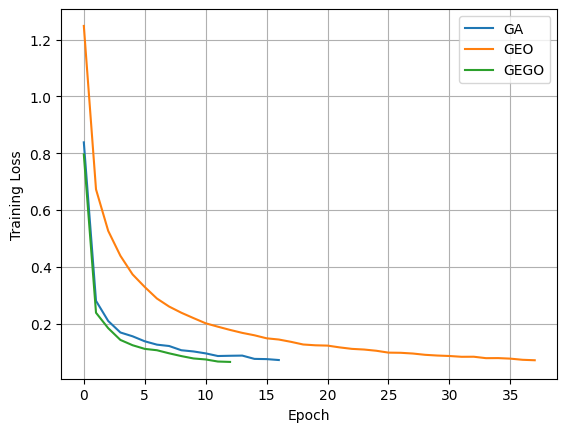

In [ ]:
plt.plot(history_ga.history['loss'],label = 'GA')
plt.plot(history_geo.history['loss'],label = 'GEO')
plt.plot(history_gego.history['loss'],label = 'GEGO')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

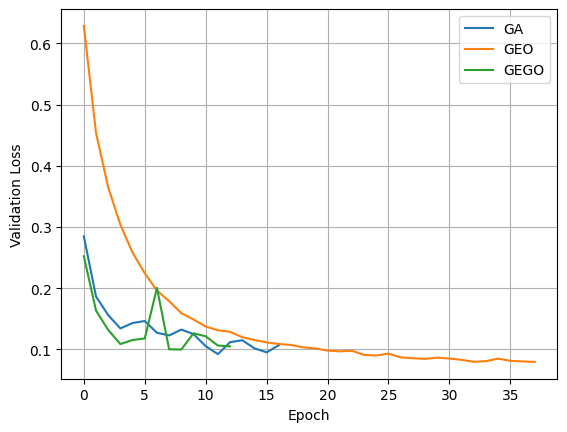

In [ ]:
plt.plot(history_ga.history['val_loss'],label = 'GA')
plt.plot(history_geo.history['val_loss'],label = 'GEO')
plt.plot(history_gego.history['val_loss'],label = 'GEGO')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)